In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
# Simulation parameters

NOISE_VAR = 2.511 * (10**(-13))
NUM_PILOTS = 4
AP_ANTENNAS = 1
side = 0.250
NUM_APs = 64
NUM_USERS = 12
p_Transmit = 0.300
CHANNEL_REALIZATIONS = 100
NUM_Schemes = 1
delta = 0.7
MIN_INTER = 0
Rho_u = p_Transmit / NOISE_VAR
Bar_4 = np.zeros((2, NUM_Schemes))
SETUPS = 5
initial = 0
NMSE_mmse_Scheme1 = np.zeros(SETUPS)
NMSE_mmse_Scheme2 = np.zeros(SETUPS)

In [4]:
def Function_ApSelection(NUM_APs, NUM_USERS, AREA_KM, delta):
    h_BS = 15  # Base station height in m
    h_mobile = 1.65  # Mobile height in m
    frequency = 1900  # Frequency in MHz
    aL = (1.1 * np.log10(frequency) - 0.7) * h_mobile - (1.56 * np.log10(frequency) - 0.8)
    L = 46.3 + 33.9 * np.log10(frequency) - 13.82 * np.log10(h_BS) - aL
    d0 = 0.01  # km
    d1 = 0.05  # km
     #random.seed(seed)
    # Uniform locations of M APs:
    AP = np.zeros((NUM_APs, 2))
    corner = int(np.sqrt(NUM_APs))
    points = (AREA_KM / corner) * np.concatenate([
        np.sort(-np.random.permutation(np.arange(1, corner // 2 + 1))),
        np.array([0]),
        np.sort(np.random.permutation(np.arange(1, corner // 2 + 1)))
    ]) - AREA_KM * (AREA_KM / 2)

    ap_coordinates = []  # List to store AP coordinates
    m = 0
    for i in range(corner):
        for j in range(corner):
            if m < NUM_APs:  # Check to avoid index error if NUM_APs is not a perfect square
                AP[m, :] = [points[i], points[j]]
                ap_coordinates.append([points[i], points[j]])  # Store AP coordinates
                m += 1

    # Wrapped around (8 neighbor cells)
    D1 = np.zeros((NUM_APs, 2))
    D1[:, 0] += AREA_KM
    AP1 = AP + D1

    D2 = np.zeros((NUM_APs, 2))
    D2[:, 1] += AREA_KM
    AP2 = AP + D2

    D3 = np.zeros((NUM_APs, 2))
    D3[:, 0] -= AREA_KM
    AP3 = AP + D3

    D4 = np.zeros((NUM_APs, 2))
    D4[:, 1] -= AREA_KM
    AP4 = AP + D4

    D5 = D1.copy()
    D5[:, 1] -= AREA_KM
    AP5 = AP + D5

    D6 = D3.copy()
    D6[:, 1] += AREA_KM
    AP6 = AP + D6

    D7 = np.ones((NUM_APs, 2)) * AREA_KM
    AP7 = AP + D7

    D8 = -np.ones((NUM_APs, 2)) * AREA_KM
    AP8 = AP + D8

    # Randomly locations of K terminals:
    Ter = np.random.uniform(-AREA_KM / 2, AREA_KM / 2, (NUM_USERS, 2))
    user_coordinates = Ter.tolist()  # Convert user coordinates to a list

    # The rest of the code...
    UEpositions = (Ter[:, 0] + AREA_KM / 2) + 1j * (Ter[:, 1] + AREA_KM / 2) * 1000
    sigma_shd = 8  # in dB
    dist_user = np.zeros((NUM_USERS, NUM_USERS))
    for t in range(NUM_USERS):
        for ut in range(t, NUM_USERS):
            dist_user[t, ut] = np.linalg.norm(Ter[t, :] - Ter[ut, :])
    # Create an MxK large-scale coefficients beta_mk
    BETAA = np.zeros((NUM_APs, NUM_USERS))
    dist = np.zeros((NUM_APs, NUM_USERS))
    for m in range(NUM_APs):
        for k in range(NUM_USERS):
            distances = np.array([
                np.linalg.norm(AP[m, :] - Ter[k, :]),
                np.linalg.norm(AP1[m, :] - Ter[k, :]),
                np.linalg.norm(AP2[m, :] - Ter[k, :]),
                np.linalg.norm(AP3[m, :] - Ter[k, :]),
                np.linalg.norm(AP4[m, :] - Ter[k, :]),
                np.linalg.norm(AP5[m, :] - Ter[k, :]),
                np.linalg.norm(AP6[m, :] - Ter[k, :]),
                np.linalg.norm(AP7[m, :] - Ter[k, :]),
                np.linalg.norm(AP8[m, :] - Ter[k, :])
            ])
            dist[m, k], _ = np.min(distances), np.argmin(distances)
            if dist[m, k] < d0:
                betadB = -L - 35 * np.log10(d1) + 20 * np.log10(d1) - 20 * np.log10(d0)
            elif d0 <= dist[m, k] <= d1:
                betadB = -L - 35 * np.log10(d1) + 20 * np.log10(d1) - 20 * np.log10(dist[m, k])
            else:
                betadB = -L - 35 * np.log10(dist[m, k]) + sigma_shd * np.random.randn()
            BETAA[m, k] = 10 ** (betadB / 10)

    beta = BETAA

    # Access point Selection matrix
    A = np.zeros((NUM_APs, NUM_USERS))
    for k in range(NUM_USERS):
        beta_sort = np.sort(beta[:, k])[::-1]
        beta_index = np.argsort(beta[:, k])[::-1]
        denom_ApSel = np.sum(beta[:, k])
        temp_ApSel = 0
        c = 0
        for m in range(NUM_APs):
            temp_ApSel += beta_sort[m]
            c += 1
            if temp_ApSel >= delta * denom_ApSel:
                break
            A[beta_index[c - 1], k] = 1
        A[beta_index[c - 1], k] = 1

    return A, beta, ap_coordinates, user_coordinates

In [5]:
def Spatial_Correlation_Matrix(A, NUM_USERS, NUM_APs, AP_ANTENNAS):
    R_corr = np.zeros((AP_ANTENNAS, AP_ANTENNAS, NUM_APs, NUM_USERS))
    for k in range(NUM_USERS):
        for l in np.where(A[:, k])[0]:
            for i in range(AP_ANTENNAS):
                for j in range(AP_ANTENNAS):
                    R_corr[i, j, l, k] = 1
    return R_corr

In [6]:
def Graph_coloring(user_coordinates):
    g=nx.Graph()
    user_nodes= range(1, NUM_USERS+1)
    g.add_nodes_from(user_nodes, node_type='user')
    for user in user_nodes:
      g.nodes[user]['pos'] = (user_coordinates[user-1][0],user_coordinates[user-1][1])
    p= nx.get_node_attributes(g, 'pos')
    nx.draw(g, p , with_labels=True, node_size=300, node_color='skyblue', font_color='black')

    d_thresh= 0.06
    for i in range(NUM_USERS):
      for j in range(i+1, NUM_USERS):
        x1=g.nodes[i+1]['pos'][0]
        y1=g.nodes[i+1]['pos'][1]
        x2=g.nodes[j+1]['pos'][0]
        y2=g.nodes[j+1]['pos'][1]

        d= np.linalg.norm(np.array([x1, y1])-np.array([x2,y2]))
        if d<d_thresh:
            g.add_edge(i+1, j+1, dummy_edge='False')

    nx.draw(g, p , with_labels=True, node_size=300, node_color='skyblue', font_color='black')

    # Convert NetworkX graph to adjacency matrix
    adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(g).toarray().astype(int)
    colors  = coloring(adjacency_matrix, 4)
    return colors

In [7]:
def Graph_coloring2(A,user_coordinates,ap_coordinates):
    g=nx.Graph()
    user_nodes= range(1, NUM_USERS+1)
    g.add_nodes_from(user_nodes, node_type='user')
    for user in user_nodes:
      g.nodes[user]['pos'] = (user_coordinates[user-1][0],user_coordinates[user-1][1])
    p= nx.get_node_attributes(g, 'pos')
    nx.draw(g, p , with_labels=True, node_size=300, node_color='skyblue', font_color='black')

    d_thresh= 0.06
    for i in range(NUM_USERS):
      for j in range(i+1, NUM_USERS):
        x1=g.nodes[i+1]['pos'][0]
        y1=g.nodes[i+1]['pos'][1]
        x2=g.nodes[j+1]['pos'][0]
        y2=g.nodes[j+1]['pos'][1]

        d= np.linalg.norm(np.array([x1, y1])-np.array([x2,y2]))
        if d<d_thresh:
            g.add_edge(i+1, j+1, dummy_edge='False')

    num_anchors=64
    anchors= range(NUM_USERS+1, NUM_USERS+num_anchors+1)
    g.add_nodes_from(anchors, node_type='anchor')
    for anchor in anchors:
      g.nodes[anchor]['pos']= (ap_coordinates[anchor-NUM_USERS-1][0],ap_coordinates[anchor-NUM_USERS-1][1])
    p= nx.get_node_attributes(g, 'pos')
    node_color= ['skyblue' if g.nodes[node]['node_type']=='user' else 'yellow' for node in g.nodes]
    common_thresh = 2
    for i in range(0,NUM_USERS-1):
      for j in range(i+1,NUM_USERS):
        count = 0
        for k in range(0,NUM_APs):
          if(A[k][i]==1 and A[k][j]==1):
            count=count+1
        if(count>=common_thresh):
          g.add_edge(i+1,j+1,dummy_edge = True)
    user1= [node for node, node_type in nx.get_node_attributes(g, 'node_type').items() if node_type=='user']
    user_g= nx.subgraph(g, user1)
    adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(user_g).toarray().astype(int)
    colors= coloring(adjacency_matrix, 4)
    return colors

In [8]:
V= NUM_USERS
limit=4
def is_safe(v, graph, color, c,count):
    for i in range(V):
        if ((graph[v][i] and c==color[i]) or count[c]==limit):
            return False
    return True

def graph_color(graph, m, color, v,count):
    if v==V:
        return True

    for c in range(1, m+1):
        if is_safe(v, graph, color, c,count):
            color[v]=c
            count[c]=count[c] + 1
            if graph_color(graph, m, color, v+1,count):
                return True

        color[v]=0
    min = 0
    for i in range(len(count)):
      if(count[i] <= count[min]):
        min = i
    color[v] = min
    count[min] = count[min] + 1
    return True

def print_solution(color):
    print("Solution Exists: Following are the assigned colors")
    for i in range(V):
        print(color[i], end=" ")
    print("\n")

def coloring(graph, m):
    color= [0]*V
    count = [0]*(m+1)
    if not graph_color(graph, m, color, 0,count):
        #print("Solution does not exist")
        return False

    #print_solution(color)
    #print("Length of color array:", len(color))  # Add this line
    return color

In [9]:
def NMSE_Calculation(A,R_corr,H,ntkl,random_pilot_assignment):
    # Channel Generation
    for k in range(NUM_USERS):
        for l in np.where(A[:, k])[0]:
            H[l, k% NUM_USERS, :] = np.sqrt(beta[l, k] / 2) * (
                    np.random.randn(1, 1, CHANNEL_REALIZATIONS) + 1j * np.random.randn(1, 1, CHANNEL_REALIZATIONS))

    # AWGN channel
    ntkl = np.sqrt(NOISE_VAR / 2) * (
            np.random.randn(NUM_APs, NUM_PILOTS, CHANNEL_REALIZATIONS) + 1j * np.random.randn(NUM_APs, NUM_PILOTS,
                                                                                                 CHANNEL_REALIZATIONS))

    # CHANNEL ESTIMATION
    Hhat_mmse = np.zeros((NUM_APs * AP_ANTENNAS, NUM_USERS, CHANNEL_REALIZATIONS), dtype=complex)
    NUM_NMSE = np.zeros((NUM_APs, NUM_USERS, CHANNEL_REALIZATIONS))
    DEN_NMSE = np.zeros((NUM_APs, NUM_USERS, CHANNEL_REALIZATIONS))
    NMSE_sample_mmse = np.zeros(CHANNEL_REALIZATIONS)
    Gammmma_each = np.zeros((NUM_APs * AP_ANTENNAS, NUM_USERS, CHANNEL_REALIZATIONS))
    Gammaa = np.zeros((NUM_APs * AP_ANTENNAS, NUM_USERS))

    # MMSE channel estimation
    for each_sam in range(CHANNEL_REALIZATIONS):
        for l in range(NUM_APs):
            for t in range(NUM_PILOTS):
                #print(f"l: {l}, t: {t}")
                indices = []
                for i in range(NUM_USERS):
                  if random_pilot_assignment[i] == t:
                    indices.append(i)
                sum = 0
                for j in indices:
                  sum = sum + H[l,j,each_sam]
                ztkl = np.sqrt(p_Transmit * NUM_PILOTS) * sum + ntkl[l, t, each_sam]
                sum1=0
                for j in indices:
                  sum1 = sum1 + R_corr[:, :, l,j]
                Psi_tkl = (p_Transmit * NUM_PILOTS * sum1
                           + np.eye(AP_ANTENNAS))

                # channel estimation of users that use pilot t
                for k in indices:
                    # only for those existing channels
                    b_linear = np.dot(R_corr[:, :, l, k], np.linalg.inv(Psi_tkl))
                    Hhat_mmse[l, k, each_sam] = np.sqrt(p_Transmit * NUM_PILOTS) * np.dot(b_linear, ztkl)

        # finding Normalized mean square error (NMSE)
        for k in range(NUM_USERS):
            for l in np.where(A[:, k])[0]:
                NUM_NMSE[l, k, each_sam] = np.abs(H[l, k, each_sam] - Hhat_mmse[l, k, each_sam]) ** 2
                DEN_NMSE[l, k, each_sam] = np.abs(H[l, k, each_sam]) ** 2

        NMSE_sample_mmse[each_sam] = np.sum(np.sum(NUM_NMSE[:, :, each_sam], axis=1), axis=0) / \
                                     np.sum(np.sum(DEN_NMSE[:, :, each_sam], axis=1), axis=0)

    return NMSE_sample_mmse

<ipython-input-9-49e8a3df1df5>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Hhat_mmse[l, k, each_sam] = np.sqrt(p_Transmit * NUM_PILOTS) * np.dot(b_linear, ztkl)


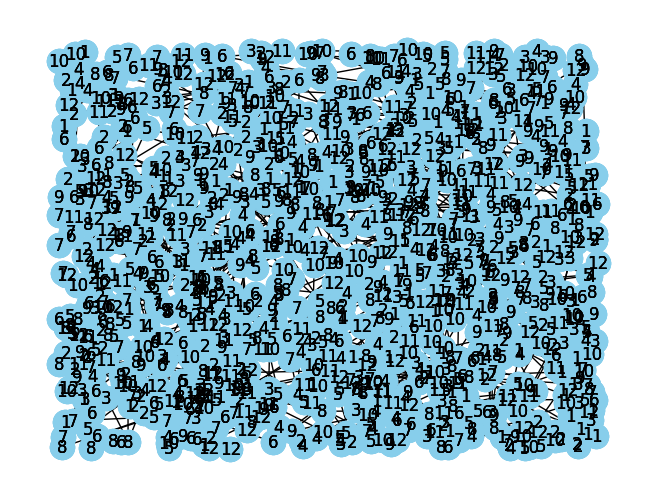

In [18]:
NMSE1 = []
NMSE2 = []
for i in range(20):
    count = 0
    for each_setup in range(SETUPS):
        # Initialization
        R_corr = np.zeros((AP_ANTENNAS, AP_ANTENNAS, NUM_APs, NUM_USERS))
        H = np.zeros((NUM_APs, NUM_USERS, CHANNEL_REALIZATIONS), dtype=complex)
        ntkl = np.zeros((NUM_APs, NUM_PILOTS, CHANNEL_REALIZATIONS), dtype=complex)

        # AP Selection
        A, beta, ap_coordinates, user_coordinates = Function_ApSelection(NUM_APs, NUM_USERS, side, delta)

        # Spatial Correlation Matrix
        R_corr = Spatial_Correlation_Matrix(A, NUM_USERS, NUM_APs, AP_ANTENNAS)

        random_pilot_assignment1 = Graph_coloring(user_coordinates)  # Random pilot assignment Scheme
        random_pilot_assignment2 = Graph_coloring2(A,user_coordinates,ap_coordinates)
        if((random_pilot_assignment1 == False) or (random_pilot_assignment2 == False)):
          continue
        count+=1
        NMSE_sample_mmse1 = NMSE_Calculation(A,R_corr,H,ntkl,random_pilot_assignment1)
        NMSE_sample_mmse2 = NMSE_Calculation(A,R_corr,H,ntkl,random_pilot_assignment2)

        NMSE_mmse_Scheme1[each_setup] = np.sum(NMSE_sample_mmse1) / (CHANNEL_REALIZATIONS)
        NMSE_mmse_Scheme2[each_setup] = np.sum(NMSE_sample_mmse2) / (CHANNEL_REALIZATIONS)

    Avg_NMSE1 = np.sum(NMSE_mmse_Scheme1) / count
    Avg_NMSE2 = np.sum(NMSE_mmse_Scheme2) / count
    if(i==0):
      NMSE1.append(Avg_NMSE1)
      NMSE2.append(Avg_NMSE2)
    else:
      NMSE1.append((Avg_NMSE1 + NMSE1[i-1]*(i))/(i+1))
      NMSE2.append((Avg_NMSE2 + NMSE2[i-1]*(i))/(i+1))

In [19]:
import matplotlib.pyplot as plt

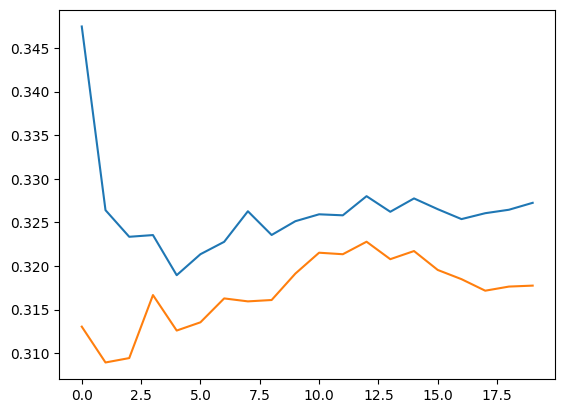

In [20]:
plt.plot(NMSE1)
plt.plot(NMSE2)
plt.show()

In [21]:
len(NMSE1)

20

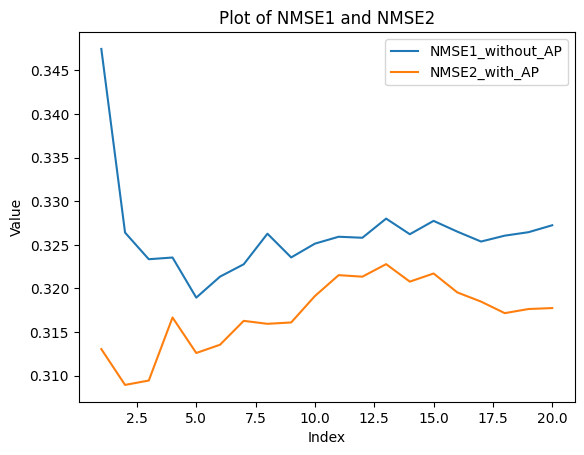

In [23]:
plt.plot(range(1, 21), NMSE1, label='NMSE1_without_AP')
plt.plot(range(1, 21), NMSE2, label='NMSE2_with_AP')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of NMSE1 and NMSE2')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
NMSE1

In [ ]:
NMSE2